# Analyzing the flexible path length simulation

In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

Load the file, and from the file pull our the engine (which tells us what the timestep was) and the move scheme (which gives us a starting point for much of the analysis).

In [2]:
# note that this log will overwrite the log from the previous notebook
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [3]:
%%time
flexible = paths.AnalysisStorage("ad_tps.nc")
# opening as AnalysisStorage is a little slower, but speeds up the move_summary

CPU times: user 1min 2s, sys: 3.52 s, total: 1min 6s
Wall time: 1min 6s


In [4]:
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [5]:
print("File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots)
))

File size: 18.65GB for 10001 steps, 985686 snapshots


That tell us a little about the file we're dealing with. Now we'll start analyzing the contents of that file. We used a very simple move scheme (only shooting), so the main information that the `move_summary` gives us is the acceptance of the only kind of move in that scheme. See the MSTIS examples for more complicated move schemes, where you want to make sure that frequency at which the move runs is close to what was expected.

In [6]:
flex_scheme.move_summary(flexible.steps)


shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 5529/10000 (55.29%)


## Replica history tree and decorrelated trajectories

The `ReplicaHistoryTree` object gives us both the history tree (often called the "move tree") and the number of decorrelated trajectories.

A `ReplicaHistoryTree` is made for a certain set of Monte Carlo steps. First, we make a tree of only the first 25 steps in order to visualize it. (All 10000 steps would be unwieldy.) 

After the visualization, we make a second `PathTree` of all the steps. We won't visualize that; instead we use it to count the number of decorrelated trajectories.

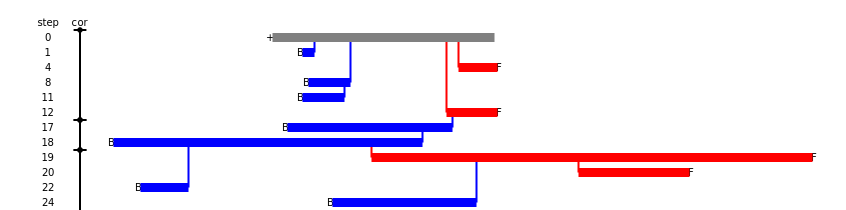

In [7]:
replica_history = ops_vis.ReplicaEvolution(replica=0)
tree = ops_vis.PathTree(
    flexible.steps[0:25],
    replica_history
)
tree.options.css['scale_x'] = 3

SVG(tree.svg())

In [8]:
# can write to svg file and open with programs that can read SVG
with open("flex_tps_tree.svg", 'w') as f:
    f.write(tree.svg())

In [9]:
print("Decorrelated trajectories:", len(tree.generator.decorrelated_trajectories))

Decorrelated trajectories: 3


In [10]:
%%time
full_history = ops_vis.PathTree(
    flexible.steps,
    ops_vis.ReplicaEvolution(
        replica=0
    )
)

n_decorrelated = len(full_history.generator.decorrelated_trajectories)

print("All decorrelated trajectories:", n_decorrelated)

All decorrelated trajectories: 846
CPU times: user 1min 22s, sys: 321 ms, total: 1min 22s
Wall time: 1min 22s


## Path length distribution

Flexible length TPS gives a distribution of path lengths. Here we calculate the length of every accepted trajectory, then histogram those lengths, and calculate the maximum and average path lengths.

We also use `engine.snapshot_timestep` to convert the count of frames to time, including correct units.

Maximum: 449 (8.980 ps)
Average: 84.56 (1.691 ps)


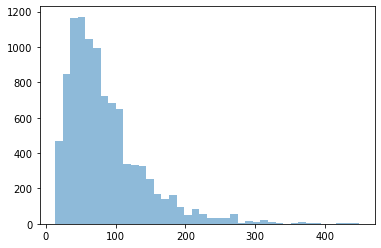

In [11]:
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40, alpha=0.5);
print("Maximum:", max(path_lengths), 
      "("+(max(path_lengths)*engine.snapshot_timestep).format("%.3f")+")")
print ("Average:", "{0:.2f}".format(np.mean(path_lengths)),
       "("+(np.mean(path_lengths)*engine.snapshot_timestep).format("%.3f")+")")

## Path density histogram

Next we will create a path density histogram. Calculating the histogram itself is quite easy: first we reload the collective variables we want to plot it in (we choose the phi and psi angles). Then we create the empty path density histogram, by telling it which CVs to use and how to make the histogram (bin sizes, etc). Finally, we build the histogram by giving it the list of active trajectories to histogram.

In [12]:
from openpathsampling.numerics import HistogramPlotter2D

In [13]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [14]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

In [15]:
path_dens_counter = path_density.histogram([s.active[0].trajectory for s in flexible.steps])

Now we've built the path density histogram, and we want to visualize it. We have a convenient `plot_2d_histogram` function that works in this case, and takes the histogram, desired plot tick labels and limits, and additional `matplotlib` named arguments to `plt.pcolormesh`.

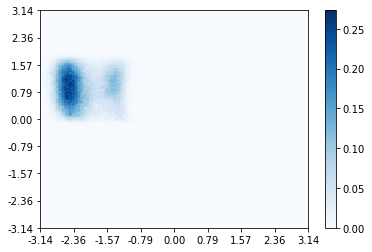

In [16]:
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4)
plotter = HistogramPlotter2D(path_density, 
                             xticklabels=tick_labels,
                             yticklabels=tick_labels, 
                             label_format="{:4.2f}")
ax = plotter.plot(cmap="Blues")

## Convert to MDTraj for analysis by external tools

The trajectory can be converted to an MDTraj trajectory, and then used anywhere that MDTraj can be used. This includes writing it to a file (in any number of file formats) or visualizing the trajectory using, e.g., NGLView.

In [17]:
ops_traj = flexible.steps[1000].active[0].trajectory
traj = ops_traj.to_mdtraj()
traj

<mdtraj.Trajectory with 44 frames, 1651 atoms, 546 residues, and unitcells at 0x145efa740510>

In [18]:
# Here's how you would then use NGLView:
#import nglview as nv
#view = nv.show_mdtraj(traj)
#view

In [19]:
flexible.close()